In [558]:
from torch import nn
import torch.nn.functional as F
import torch.utils.data
import matplotlib.pyplot as plt

In [559]:
import tensorflow as tf
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [560]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5)
        self.fc1 = nn.Linear(in_features=20*4*4, out_features=50)
        self.fc2 = nn.Linear(in_features=50, out_features=10)

    def forward(self, x):
        x = F.relu(self.conv1(x)) # BSx10x24x24
        x = F.max_pool2d(x, kernel_size=2, stride=2) # BSx10x12x12
        x = F.relu(self.conv2(x)) # BSx20x8x8
        x = F.max_pool2d(x, kernel_size=2, stride=2) # BSx20x4x4
        x = x.view(-1, 20*4*4) # BSx320
        x = F.relu(self.fc1(x)) # BSx50
        x = self.fc2(x) # BSx10
        return x

In [561]:
model = CNN()
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
losses, accuracies = [], []

In [562]:
EPOCHS = 3
BS = 100
num_batches = x_train.shape[0] // BS

In [563]:
model.train()
for epoch in range(EPOCHS):
    idx = torch.randperm(x_train.shape[0])
    xs = torch.tensor(x_train[idx]).view(num_batches, BS, 28, 28).float()
    ys = torch.tensor(y_train[idx]).view(num_batches, BS)
    for batch in range(num_batches):
        out = model(xs[batch].view(BS, 1, 28, 28))
        pred = torch.argmax(out, dim=1)
        accuracy = (ys[batch] == pred).float().mean()
        model.zero_grad()
        loss = loss_function(out, ys[batch])
        loss.backward()
        optimizer.step()
        loss, accuracy = loss.item(), accuracy.item()
        losses.append(loss)
        accuracies.append(accuracy)
        if batch % 100 == 0: print("step %3d: loss %.2f, accuracy %.2f" % (batch, losses[-1], accuracies[-1]))
    print("---------- END EPOCH %d ----------" % epoch)

step   0: loss 8.16, accuracy 0.13
step 100: loss 0.22, accuracy 0.94
step 200: loss 0.15, accuracy 0.94
step 300: loss 0.05, accuracy 1.00
step 400: loss 0.10, accuracy 0.96
step 500: loss 0.08, accuracy 0.97
---------- END EPOCH 0 ----------
step   0: loss 0.12, accuracy 0.96
step 100: loss 0.10, accuracy 0.95
step 200: loss 0.03, accuracy 0.99
step 300: loss 0.04, accuracy 0.98
step 400: loss 0.14, accuracy 0.98
step 500: loss 0.05, accuracy 0.98
---------- END EPOCH 1 ----------
step   0: loss 0.01, accuracy 1.00
step 100: loss 0.03, accuracy 0.99
step 200: loss 0.04, accuracy 0.99
step 300: loss 0.02, accuracy 0.99
step 400: loss 0.03, accuracy 0.98
step 500: loss 0.10, accuracy 0.96
---------- END EPOCH 2 ----------


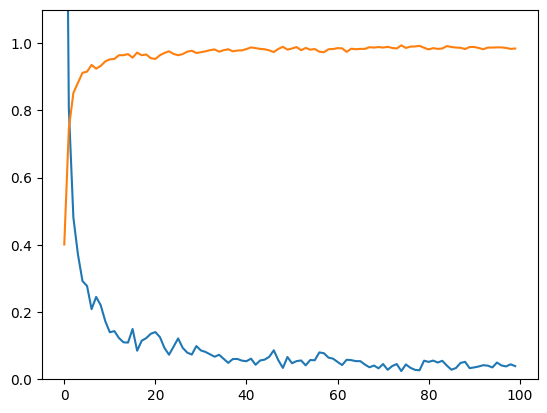

In [564]:
plt.ylim(0, 1.1)
plt.plot(torch.tensor(losses).view(100, -1).mean(axis=1))
plt.plot(torch.tensor(accuracies).view(100, -1).mean(axis=1))

In [565]:
model.eval()
with torch.no_grad():
    xs = torch.tensor(x_test).view(-1, 1, 28, 28).float()
    ys = torch.tensor(y_test)
    out = model(xs)
    pred = torch.argmax(out, dim=1)
    accuracy = (ys == pred).float().mean()
    loss = loss_function(out, ys)
print("test accuracy: %.2f" % (accuracy.item()))

test accuracy: 0.99


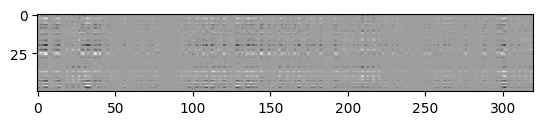

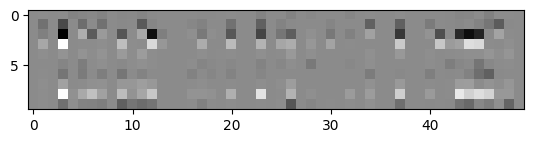

In [566]:
plt.imshow(model.fc1.weight.grad, cmap="gray")
plt.figure()
plt.imshow(model.fc2.weight.grad, cmap="gray")